In [1]:
import os
import h5py
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import skimage
import imageio

import tifffile as tf
import cv2

import pyclesperanto_prototype as cle
from skimage.exposure import match_histograms, rescale_intensity
from skimage import exposure, util, filters, restoration

import pandas as pd

from cellpose import models,core

C:\Users\mwang698\AppData\Local\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
def contrast_str(img, n_min=10, n_max=100):
    p2, p98 = np.percentile(img, (n_min, n_max))
    img_rescale = rescale_intensity(img, in_range=(p2, p98))
    img_rescale = util.img_as_ubyte(img_rescale)
    return img_rescale

In [3]:
def extract_numeric(filename):
    return int(filename.split('_')[-1].split('.')[0])

In [4]:
if core.use_gpu()==False: 
    use_GPU=False
else:
    print('GPU applied')
    use_GPU=True

GPU applied


In [ ]:
# cytotoxic T cell
imgs_processed_all_cytotoxic = []

path1 = r"Y:\coskun-lab\Thomas\20_MouseCocultureMatrigel\data\CytoCoc\hdf5\processed\CD8T_pos1_5.hdf5"
path2 = r"Y:\coskun-lab\Thomas\20_MouseCocultureMatrigel\data\CytoCoc\hdf5\processed\CD8T_pos2_16.hdf5"

for path in [path1, path2]:
    with h5py.File(path, "r") as f:
        markers_cytotoxic = f['imgs'].attrs['Marker']
        imgs = f['imgs'][:]
    imgs_processed = skimage.exposure.adjust_log(imgs) 
    imgs_processed  = np.clip(imgs_processed , a_min=0, a_max=imgs_processed.max())
    imgs_processed = contrast_str(imgs_processed, n_min=0, n_max=100)
    imgs_processed_all_cytotoxic.append(imgs_processed)

In [ ]:
# naive T cell
imgs_processed_all_naive = []

path1 = r"Y:\coskun-lab\Thomas\20_MouseCocultureMatrigel\data\NaiveCoC\hdf5\processed\CD8T_pos1_10.hdf5"
path2 = r"Y:\coskun-lab\Thomas\20_MouseCocultureMatrigel\data\NaiveCoC\hdf5\processed\CD8T_pos2_10.hdf5"

for path in [path1, path2]:
    with h5py.File(path, "r") as f:
        markers_naive = f['imgs'].attrs['Marker']
        imgs = f['imgs'][:]

    imgs_processed = skimage.exposure.adjust_log(imgs) 
    imgs_processed  = np.clip(imgs_processed , a_min=0, a_max=imgs_processed.max())
    imgs_processed = contrast_str(imgs_processed, n_min=0, n_max=100)
    imgs_processed_all_naive.append(imgs_processed)

In [7]:
from joblib import Parallel, delayed
from skimage import measure
from functools import reduce

### Helper function
def read_intensity_per_cell(img, mask):
    props = skimage.measure.regionprops_table(
        mask, img, properties=["label", "mean_intensity", "area"]
    )
    df_prop = pd.DataFrame(props)
    df_prop["mean_intensity"] = df_prop["mean_intensity"]
    df_prop.drop("area", axis=1, inplace=True)

    df_prop["mean_intensity"] = np.arcsinh(df_prop[["mean_intensity"]])

    return df_prop

def create_cell_mean_expression(mask, cell2int, **kwargs):
    img = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.uint8)

    for cell, int in cell2int.items():
        img = np.where(mask == cell, int, img)
    return img

In [8]:
from skimage.io import imread
naive_cyto_mask_pos1 = imread("Y:\coskun-undergrads\Mingshuang\Thomas\CoCulture\imgs\masks\CD8T_pos1_10_cp_masks.png")
naive_cyto_mask_pos2 = imread("Y:\coskun-undergrads\Mingshuang\Thomas\CoCulture\imgs\masks\CD8T_pos2_10_cp_masks.png")

cytotoxic_cyto_mask_pos1 = tf.imread(r"Y:\coskun-lab\Thomas\20_MouseCocultureMatrigel\data\CytoCoc\masks\pos1_5.tif")
cytotoxic_cyto_mask_pos2 = tf.imread(r"Y:\coskun-lab\Thomas\20_MouseCocultureMatrigel\data\CytoCoc\masks\pos2_16.tif")

In [9]:
# Cytotoxic

# Extract mean intensity per mask
cyto_masks_cytotoxic = [cytotoxic_cyto_mask_pos1, cytotoxic_cyto_mask_pos2]
# df_appended_list_cytotoxic = pd.DataFrame()
df_appended_list_cytotoxic_all = []
for i, img_processed in enumerate(imgs_processed_all_cytotoxic):
    cyto_mask = cyto_masks_cytotoxic[i]
    df_appended_list = []
    for i, img in enumerate(img_processed):
        if markers_cytotoxic[i] == 'DNA' and i != 0:
            continue 
        df_prop = read_intensity_per_cell(img, cyto_mask)
        df_prop.columns = ["Cell_label", markers_cytotoxic[i]]
        df_appended_list.append(df_prop)
    df_appended_list_cytotoxic_all.append(df_appended_list)


In [10]:
# Naive

# Extract mean intensity per mask
cyto_masks_naive = [naive_cyto_mask_pos1, naive_cyto_mask_pos2]
df_appended_list_naive_all = []
for i, img_processed in enumerate(imgs_processed_all_naive):
    cyto_mask = cyto_masks_naive[i]
    df_appended_list = []
    for i, img in enumerate(img_processed):
        if markers_naive[i] == 'DNA' and i != 0:
            continue 
        df_prop = read_intensity_per_cell(img, cyto_mask)
        df_prop.columns = ["Cell_label", markers_naive[i]]
        df_appended_list.append(df_prop)
    df_appended_list_naive_all.append(df_appended_list)


In [11]:
# cytotoxic
df_cell_intensity_pos1_cyto = reduce(
    lambda left, right: pd.merge(left, right, on=["Cell_label"]),
    df_appended_list_cytotoxic_all[0],
)

df_cell_intensity_pos2_cyto = reduce(
    lambda left, right: pd.merge(left, right, on=["Cell_label"]),
    df_appended_list_cytotoxic_all[1],
)

In [12]:
# naive
df_cell_intensity_pos1_naive = reduce(
    lambda left, right: pd.merge(left, right, on=["Cell_label"]),
    df_appended_list_naive_all[0],
)

df_cell_intensity_pos2_naive = reduce(
    lambda left, right: pd.merge(left, right, on=["Cell_label"]),
    df_appended_list_naive_all[1],
)

In [13]:
# cytotoxic
props = skimage.measure.regionprops_table(
    cytotoxic_cyto_mask_pos1, properties=["label", "centroid"]
)
rows = props["centroid-0"] 
cols = props["centroid-1"] 
centroid_cytotoxic = np.array(list(zip(cols, rows)))
df_cell_intensity_pos1_cyto['Row'] = rows
df_cell_intensity_pos1_cyto['Cols'] = cols
df_cell_intensity_pos1_cyto['FOV'] = 'pos1'
df_prop_cytotoxic = df_cell_intensity_pos1_cyto

props = skimage.measure.regionprops_table(
    cytotoxic_cyto_mask_pos2, properties=["label", "centroid"]
)
rows = props["centroid-0"] 
cols = props["centroid-1"] 
centroid_cytotoxic = np.concatenate([centroid_cytotoxic, np.array(list(zip(cols, rows)))])
df_cell_intensity_pos2_cyto['Row'] = rows
df_cell_intensity_pos2_cyto['Cols'] = cols
df_cell_intensity_pos2_cyto['FOV'] = 'pos2'
df_prop_cytotoxic = df_prop_cytotoxic.append(df_cell_intensity_pos2_cyto)

C:\Users\mwang698\AppData\Local\Temp\ipykernel_39384\210281673.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_prop_cytotoxic = df_prop_cytotoxic.append(df_cell_intensity_pos2_cyto)


In [14]:
# naive
props = skimage.measure.regionprops_table(
    naive_cyto_mask_pos1, properties=["label", "centroid"]
)
rows = props["centroid-0"] 
cols = props["centroid-1"] 
centroid_naive = np.array(list(zip(cols, rows)))
df_cell_intensity_pos1_naive['Row'] = rows
df_cell_intensity_pos1_naive['Cols'] = cols
df_cell_intensity_pos1_naive['FOV'] = 'pos1'
df_prop_naive = df_cell_intensity_pos1_naive

props = skimage.measure.regionprops_table(
    naive_cyto_mask_pos2, properties=["label", "centroid"]
)
rows = props["centroid-0"] 
cols = props["centroid-1"] 
centroid_naive = np.concatenate([centroid_naive, np.array(list(zip(cols, rows)))])
df_cell_intensity_pos2_naive['Row'] = rows
df_cell_intensity_pos2_naive['Cols'] = cols
df_cell_intensity_pos2_naive['FOV'] = 'pos2'
df_prop_naive = df_prop_naive.append(df_cell_intensity_pos2_naive)

C:\Users\mwang698\AppData\Local\Temp\ipykernel_39384\3326929780.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_prop_naive = df_prop_naive.append(df_cell_intensity_pos2_naive)


In [15]:
df_DNA_cyto = df_prop_cytotoxic[['DNA']].copy()
df_marker_cyto = df_prop_cytotoxic[['CD44','E-cadherin']].copy()

df_DNA_naive = df_prop_naive[['DNA']].copy()
df_marker_naive = df_prop_naive[['CD44','E-cadherin']].copy()

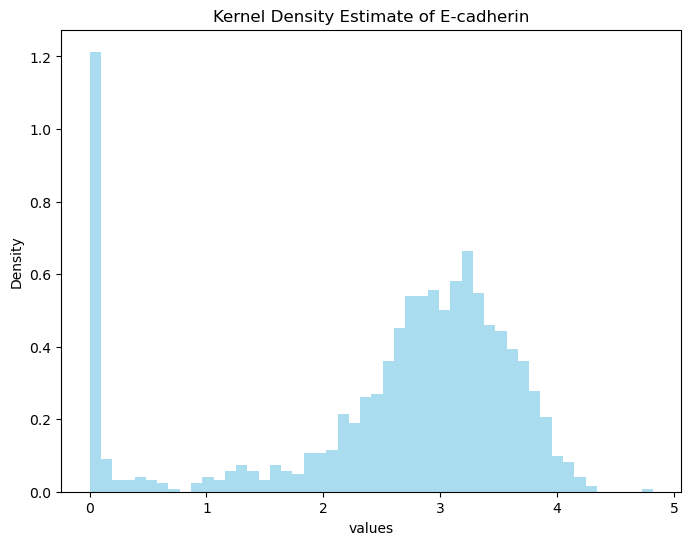

In [30]:
# df_ph_naive = df_prop_naive[['Phalloidin']].copy()
# import matplotlib.pyplot as plt

# # Extract the 'E-cadherin' column from df_subset
# ecad_values = df_ph_naive['Phalloidin']

# # Create a kernel density estimate plot using Matplotlib
# plt.figure(figsize=(8, 6))
# plt.hist(ecad_values, bins=50, density=True, alpha=0.7, color='skyblue')
# # plt.boxplot(ecad_values)
# plt.title('Kernel Density Estimate of E-cadherin')
# plt.xlabel('values')
# plt.ylabel('Density')
# plt.grid(False)
# plt.show()


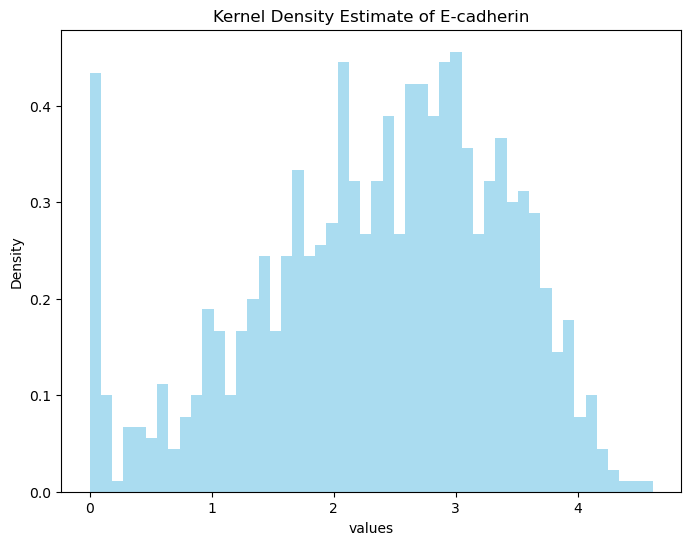

In [32]:
# df_ph_cyto = df_prop_cytotoxic[['Phalloidin']].copy()
# import matplotlib.pyplot as plt

# # Extract the 'E-cadherin' column from df_subset
# ecad_values = df_ph_cyto['Phalloidin']

# # Create a kernel density estimate plot using Matplotlib
# plt.figure(figsize=(8, 6))
# plt.hist(ecad_values, bins=50, density=True, alpha=0.7, color='skyblue')
# # plt.boxplot(ecad_values)
# plt.title('Kernel Density Estimate of E-cadherin')
# plt.xlabel('values')
# plt.ylabel('Density')
# plt.grid(False)
# plt.show()


In [16]:
centroid_cytotoxic = centroid_cytotoxic[df_prop_cytotoxic['DNA'] > 2, :]
df_prop_cytotoxic = df_prop_cytotoxic[df_prop_cytotoxic['DNA'] > 2]

centroid_naive = centroid_naive[df_prop_naive['DNA'] > 2, :]
df_prop_naive = df_prop_naive[df_prop_naive['DNA'] > 2]

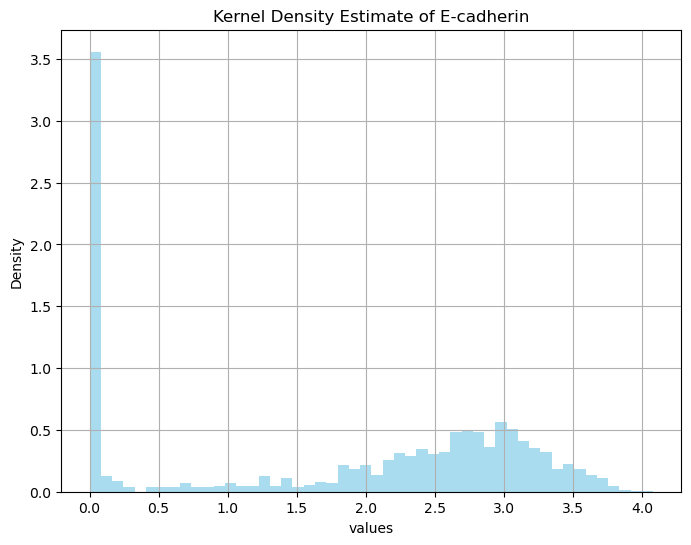

In [17]:
import matplotlib.pyplot as plt

# Extract the 'E-cadherin' column from df_subset
ecad_values = df_marker_naive['E-cadherin']

# Create a kernel density estimate plot using Matplotlib
plt.figure(figsize=(8, 6))
plt.hist(ecad_values, bins=50, density=True, alpha=0.7, color='skyblue')
# plt.boxplot(ecad_values)
plt.title('Kernel Density Estimate of E-cadherin')
plt.xlabel('values')
plt.ylabel('Density')
plt.grid(True)
plt.show()


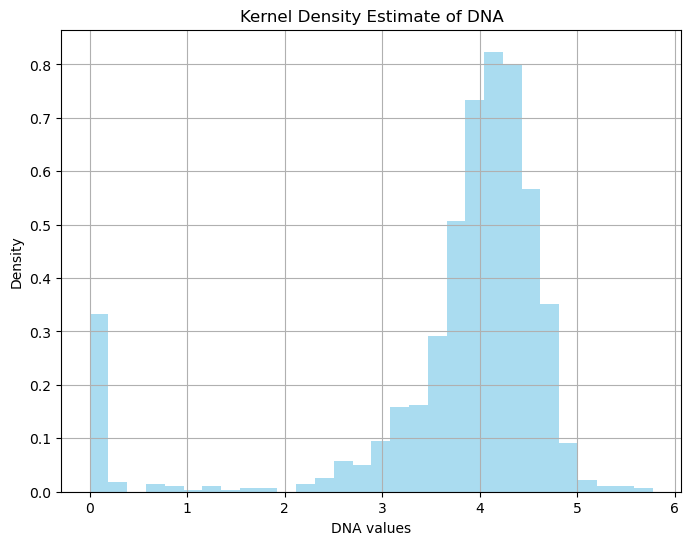

In [18]:
import matplotlib.pyplot as plt

# Extract the 'E-cadherin' column from df_subset
ecad_values = df_DNA_naive['DNA']

# Create a kernel density estimate plot using Matplotlib
plt.figure(figsize=(8, 6))
plt.hist(ecad_values, bins=30, density=True, alpha=0.7, color='skyblue')
# plt.boxplot(ecad_values)
plt.title('Kernel Density Estimate of DNA')
plt.xlabel('DNA values')
plt.ylabel('Density')
plt.grid(True)
plt.show()


In [19]:
# Define cell type
df_prop_cytotoxic['Cell Type'] = 0
df_prop_cytotoxic.loc[df_prop_cytotoxic['E-cadherin'] > 0.1, 'Cell Type'] = 1
df_prop_cytotoxic.loc[df_prop_cytotoxic['E-cadherin'] <= 0.1, 'Cell Type'] = 2

In [20]:
# Define cell type
df_prop_naive['Cell Type'] = 0
df_prop_naive.loc[df_prop_naive['E-cadherin'] > 0.1, 'Cell Type'] = 1
df_prop_naive.loc[df_prop_naive['E-cadherin'] <= 0.1, 'Cell Type'] = 2

In [21]:
df_prop_cytotoxic['Cell_type_name'] = df_prop_cytotoxic['Cell Type'].apply(lambda x: {0:'Other', 1: 'Cancer cell', 2:'Cytotoxic T cell'}.get(x,x))
df_cytotoxic = df_prop_cytotoxic.loc[:,np.concatenate([markers_cytotoxic, ['Cell_type_name']])].copy()
df_cytotoxic = df_cytotoxic[df_cytotoxic.Cell_type_name != 'Other']

In [22]:
df_prop_naive['Cell_type_name'] = df_prop_naive['Cell Type'].apply(lambda x: {0:'Other', 1: 'Cancer cell', 2:'Naive T cell'}.get(x,x))
df_naive = df_prop_naive.loc[:,np.concatenate([markers_naive, ['Cell_type_name']])].copy()
df_naive = df_naive[df_naive.Cell_type_name != 'Other']

In [23]:
from statannotations.Annotator import Annotator

def plot(plotting, figsize=(24,7)):
    c1, c2 = plotting['data'][plotting['hue']].unique()
    pairs = [((e, c1), (e, c2)) for e in plotting['data'][plotting['x']].unique()]

    with sns.plotting_context('talk', font_scale=1.5):
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.boxplot(**plotting, showfliers=False, ax=ax)
        # ax = sns.swarmplot(**plotting, ax=ax, dodge=True, size=2.5)
        annot = Annotator(ax, pairs, **plotting)
        annot.configure(test='Mann-Whitney', text_format='star',comparisons_correction="bonferroni",loc='inside', verbose=0)
        result = annot.apply_test().annotate()
        plt.xticks(rotation=30, ha='right')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        
def plot3(plotting, figsize=(37,8)):
    c1, c2, c3 = plotting['data'][plotting['hue']].unique()
    pairs = [((e, c1), (e, c2), (e, c3)) for e in plotting['data'][plotting['x']].unique()]
    pairs = []
    for e in plotting['data'][plotting['x']].unique():
        pairs.append([(e, c1), (e, c2)])
        pairs.append([(e, c1), (e, c3)])
        pairs.append([(e, c2), (e, c3)])

    with sns.plotting_context('talk', font_scale=1.5):
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.boxplot(**plotting, showfliers=False, ax=ax)
        # ax = sns.swarmplot(**plotting, ax=ax, dodge=True, size=2.5)
        annot = Annotator(ax, pairs, **plotting)
        annot.configure(test='Mann-Whitney', text_format='star', comparisons_correction="bonferroni", loc='inside')
#         result = annot.apply_test().annotate()
        _, corrected_results = annot.apply_and_annotate()
        plt.xticks(rotation=30, ha='right')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

def plot2(plotting, figsize=(24,7)):
    c1, c2 = plotting['data'][plotting['hue']].unique()
    pairs = [((e, c1), (e, c2)) for e in plotting['data'][plotting['x']].unique()]

    with sns.plotting_context('talk', font_scale=1.5):
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.violinplot(**plotting, showfliers=False, ax=ax)
        annot = Annotator(ax, pairs, **plotting)
        annot.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose=0)
        result = annot.apply_test().annotate()
        plt.xticks(rotation=30, ha='right')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

In [24]:
df_cytotoxic_value = df_cytotoxic.iloc[:,0:44].copy()
df_cytotoxic_value_norm = (df_cytotoxic_value - df_cytotoxic_value.min()) / (df_cytotoxic_value.max() - df_cytotoxic_value.min())
df_cytotoxic_value_norm = df_cytotoxic_value_norm.loc[:,~df_cytotoxic_value_norm.columns.duplicated()].copy()

phalloidin_mean = df_cytotoxic_value_norm['Phalloidin'].mean()
    
for column in df_cytotoxic_value_norm.columns:
    df_cytotoxic_value_norm[column] -= phalloidin_mean
        
df_cytotoxic_value_norm['Cell_type_name'] = df_cytotoxic['Cell_type_name']

In [25]:
df_naive_value = df_naive.iloc[:,0:41].copy()
df_naive_value_norm = (df_naive_value - df_naive_value.min()) / (df_naive_value.max() - df_naive_value.min())
df_naive_value_norm = df_naive_value_norm.loc[:,~df_naive_value_norm.columns.duplicated()].copy()

phalloidin_mean = df_naive_value_norm['Phalloidin'].mean()
    
for column in df_naive_value_norm.columns:
    df_naive_value_norm[column] -= phalloidin_mean
        
df_naive_value_norm['Cell_type_name'] = df_naive['Cell_type_name']

In [26]:
df_melt_cytotoxic = df_cytotoxic_value_norm.melt(id_vars=['Cell_type_name'])
df_melt_cytotoxic.columns = ['Cell Type', 'Marker', 'Expression']
df_melt_cytotoxic.head()


,Cell Type,Marker,Expression
0,Cytotoxic T cell,DNA,0.117196
1,Cytotoxic T cell,DNA,0.042485
2,Cancer cell,DNA,-0.055211
3,Cancer cell,DNA,0.240569
4,Cancer cell,DNA,0.370331


In [27]:
df_melt_naive = df_naive_value_norm.melt(id_vars=['Cell_type_name'])
df_melt_naive.columns = ['Cell Type', 'Marker', 'Expression']
df_melt_naive.head()


,Cell Type,Marker,Expression
0,Cancer cell,DNA,0.072083
1,Cancer cell,DNA,0.005246
2,Naive T cell,DNA,0.133053
3,Naive T cell,DNA,-0.018707
4,Cancer cell,DNA,-0.069858


In [28]:
df_melt_all = pd.concat([df_melt_naive, df_melt_cytotoxic])

In [29]:
df_melt_all_corrected = df_melt_all[(~(df_melt_all['Marker'] == 'WGA'))]
df_melt_all_corrected = df_melt_all_corrected[(~(df_melt_all_corrected['Marker'] == 'Concavalin A'))]

In [30]:
df_melt_all_corrected = df_melt_all_corrected[~(df_melt_all_corrected['Cell Type'] == 'Cancer cell')]

In [31]:
df_melt_all_corrected

,Cell Type,Marker,Expression
2,Naive T cell,DNA,0.133053
3,Naive T cell,DNA,-0.018707
5,Naive T cell,DNA,0.034610
7,Naive T cell,DNA,-0.143057
8,Naive T cell,DNA,-0.043508
...,...,...,...
30185,Cytotoxic T cell,Ki67,-0.506389
30186,Cytotoxic T cell,Ki67,-0.507959
30188,Cytotoxic T cell,Ki67,-0.512117
30189,Cytotoxic T cell,Ki67,-0.512559


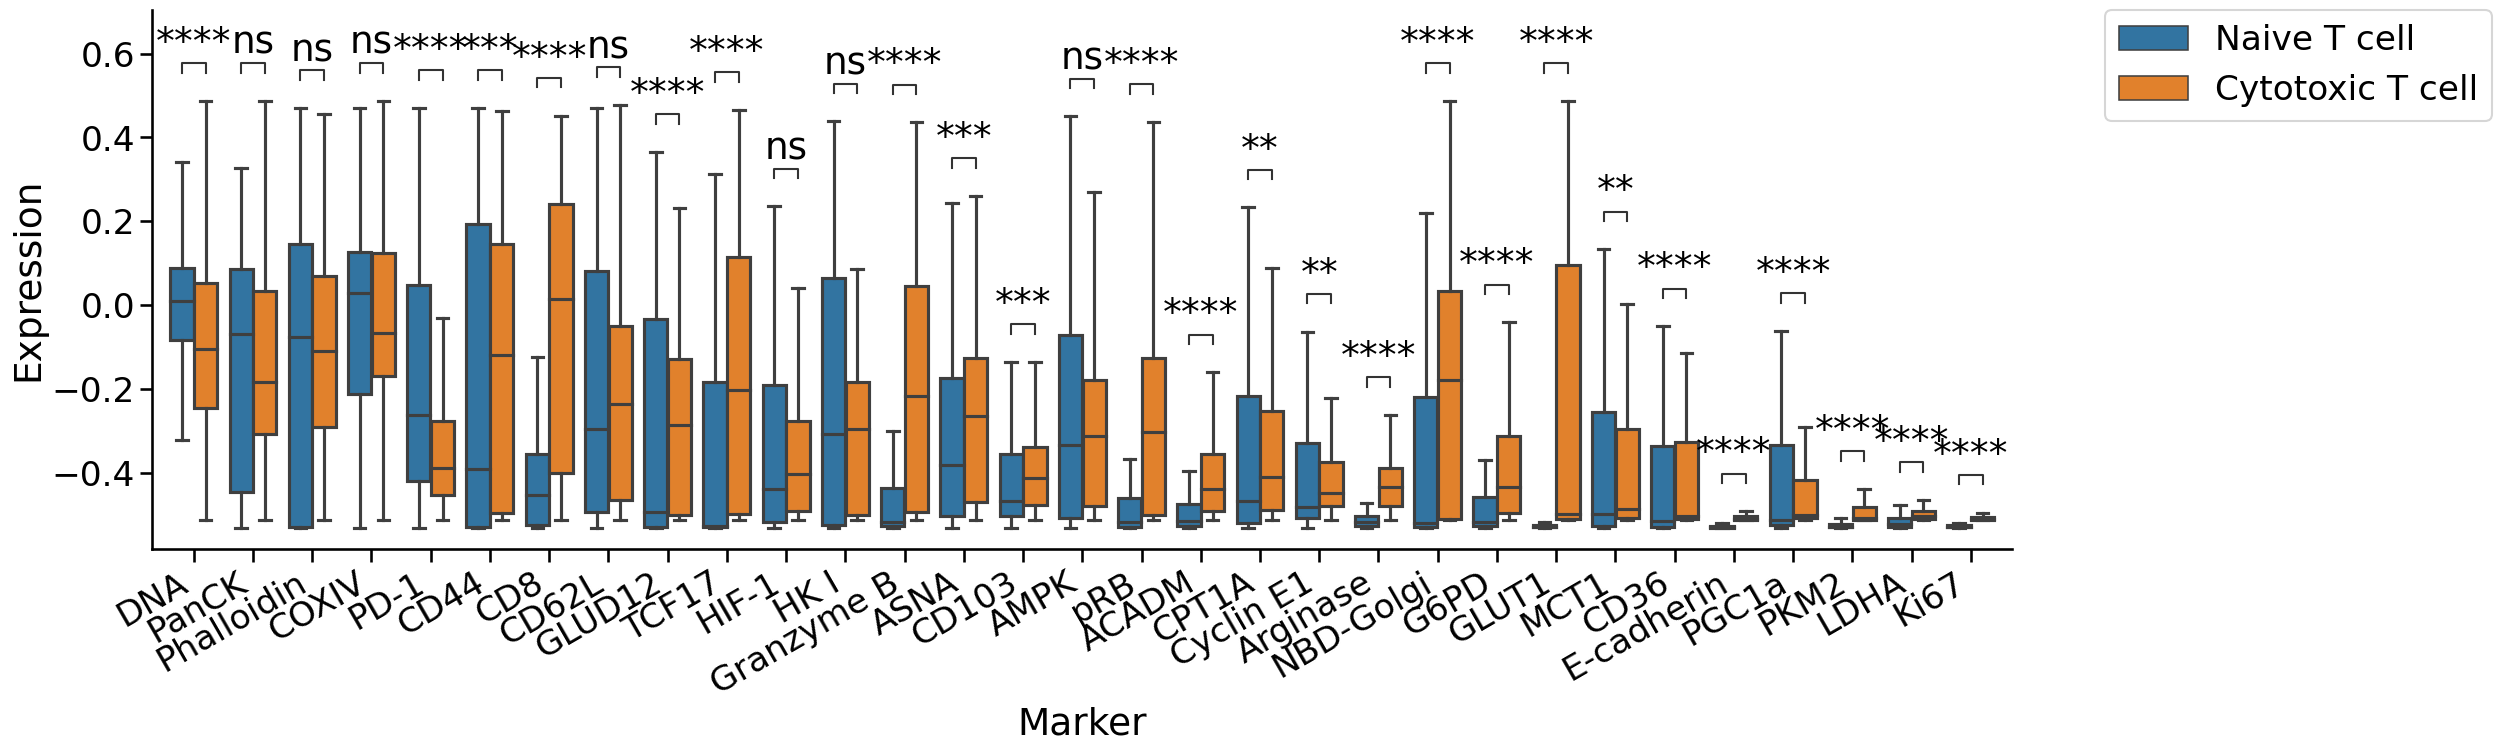

In [32]:
# Boxplot per cell
import seaborn as sns
plotting = {
    "data": df_melt_all_corrected,
    "x": "Marker",
    "y": "Expression",
    "hue": "Cell Type"
}

plot(plotting)
sns.despine()

In [33]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder
import scanpy as sc

def get_distance(centroid_fit, centroid_search):
    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(centroid_fit)

    d, n = neigh.kneighbors(centroid_search, return_distance=True)

    return d

In [34]:
centroid_cytotoxic_copy = centroid_cytotoxic.copy()
centroid_naive_copy = centroid_naive.copy()

In [35]:
# df_pos1 = df_cell_intensity[df_cell_intensity['FOV'] == 'pos1']
# df_pos2 = df_cell_intensity[df_cell_intensity['FOV'] == 'pos2']
df_pos1_cytotoxic = df_prop_cytotoxic[df_prop_cytotoxic['FOV'] == 'pos1']
df_pos2_cytotoxic = df_prop_cytotoxic[df_prop_cytotoxic['FOV'] == 'pos2']

df_pos1_naive = df_prop_naive[df_prop_naive['FOV'] == 'pos1']
df_pos2_naive = df_prop_naive[df_prop_naive['FOV'] == 'pos2']

In [ ]:
#cytotoxic

# Get distance
centroid_all_pos1_cyto = centroid_cytotoxic[df_prop_cytotoxic.FOV == 'pos1']
centroid_tcell_pos1_cyto = centroid_all_pos1_cyto[df_pos1_cytotoxic.Cell_type_name == 'Cytotoxic T cell']
d = get_distance(centroid_tcell_pos1_cyto, centroid_all_pos1_cyto)

# Assign to dataframe
df_pos1_cytotoxic['Distance to T-cell'] = d

# Get distance
centroid_all_pos2_cyto = centroid_cytotoxic[df_prop_cytotoxic.FOV == 'pos2']
centroid_tcell_pos2_cyto = centroid_all_pos2_cyto[df_pos2_cytotoxic.Cell_type_name == 'Cytotoxic T cell']
d = get_distance(centroid_tcell_pos2_cyto, centroid_all_pos2_cyto)

# Assign to dataframe
df_pos2_cytotoxic['Distance to T-cell'] = d

In [ ]:
#naive

# Get distance
centroid_all_pos1_naive = centroid_naive[df_prop_naive.FOV == 'pos1']
centroid_tcell_pos1_naive = centroid_all_pos1_naive[df_pos1_naive.Cell_type_name == 'Naive T cell']
d = get_distance(centroid_tcell_pos1_naive, centroid_all_pos1_naive)

# Assign to dataframe
df_pos1_naive['Distance to T-cell'] = d

# Get distance
centroid_all_pos2_naive = centroid_naive[df_prop_naive.FOV == 'pos2']
centroid_tcell_pos2_naive = centroid_all_pos2_naive[df_pos2_naive.Cell_type_name == 'Naive T cell']
d = get_distance(centroid_tcell_pos2_naive, centroid_all_pos2_naive)

# Assign to dataframe
df_pos2_naive['Distance to T-cell'] = d

In [38]:
df_both_cytotoxic = pd.concat([df_pos1_cytotoxic, df_pos2_cytotoxic])
df_both_naive = pd.concat([df_pos1_naive, df_pos2_naive])

In [133]:
# Tumor cell: marker expression versus distance with respect to T cell:
# Get distance
df_cancer_cyto = df_both_cytotoxic[df_both_cytotoxic.Cell_type_name == 'Cancer cell'].copy()
df_cancer_cyto.drop(['Row', 'Cols', 'FOV', 'Cell Type', 'Cell_type_name', 'Cell_label'], axis=1, inplace=True)
df_cancer_cyto['neighbor'] = 'Cytotoxic T cell'


df_cancer_naive = df_both_naive[df_both_naive.Cell_type_name == 'Cancer cell'].copy()
df_cancer_naive.drop(['Row', 'Cols', 'FOV', 'Cell Type', 'Cell_type_name', 'Cell_label'], axis=1, inplace=True)
df_cancer_naive['neighbor'] = 'Naive T cell'

df_all_cancer = pd.concat([df_cancer_cyto, df_cancer_naive])
# df_cancer_naive.sort_values('Distance to T-cell', inplace=True)
# Melt dataframe
#df_melt_cyto = df_cancer_cyto.drop(['Distance to T-cell'], axis=1).melt(id_vars='Distance T-cell', var_name='Marker', value_name='Expression')


<Axes: xlabel='Distance to T-cell', ylabel='Ki67'>

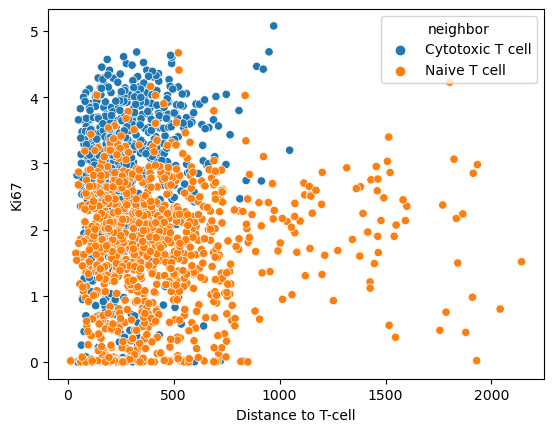

In [134]:
sns.scatterplot(data=df_all_cancer, x="Distance to T-cell", y="Ki67", hue = 'neighbor')

In [135]:
df_all_cancer[f'Distance T-cell'] = pd.qcut(df_all_cancer['Distance to T-cell'], 10, duplicates='drop')
LE = LabelEncoder()
df_all_cancer[f'Distance T-cell'] = LE.fit_transform(df_all_cancer[f'Distance T-cell'])

In [136]:
df_all_cancer.drop(['Distance to T-cell'], axis=1, inplace=True)

<Axes: xlabel='Distance T-cell', ylabel='DNA'>

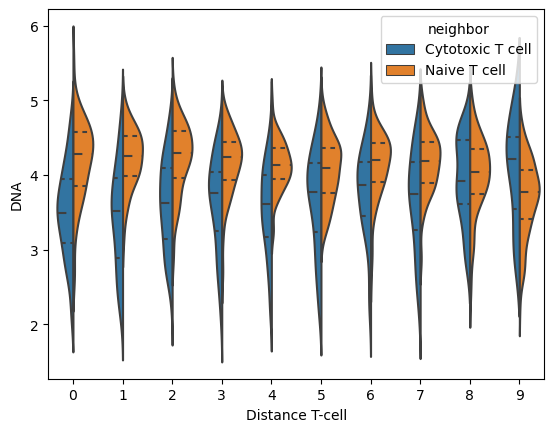

In [137]:
# sns.violinplot(data=df_all_cancer, x="Distance T-cell", y="DNA", hue="neighbor", split=True, inner="quart")

In [139]:
# from anndata import AnnData
# adata_cancer = AnnData(X=df_all_cancer.iloc[:, :31].values, obs=df_all_cancer.iloc[:, -2:], var=pd.DataFrame(df_all_cancer.columns[0:31].values))

C:\Users\mwang698\AppData\Local\anaconda3\Lib\site-packages\anndata\_core\anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
C:\Users\mwang698\AppData\Local\anaconda3\Lib\site-packages\anndata\_core\anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
C:\Users\mwang698\AppData\Local\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1898: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [140]:
# adata_cancer.var_names = df_all_cancer.columns[0:31]

In [141]:
# adata_cancer.obs['group'] = adata_cancer.obs['Distance T-cell'].astype(str) + '_' + adata_cancer.obs['neighbor']

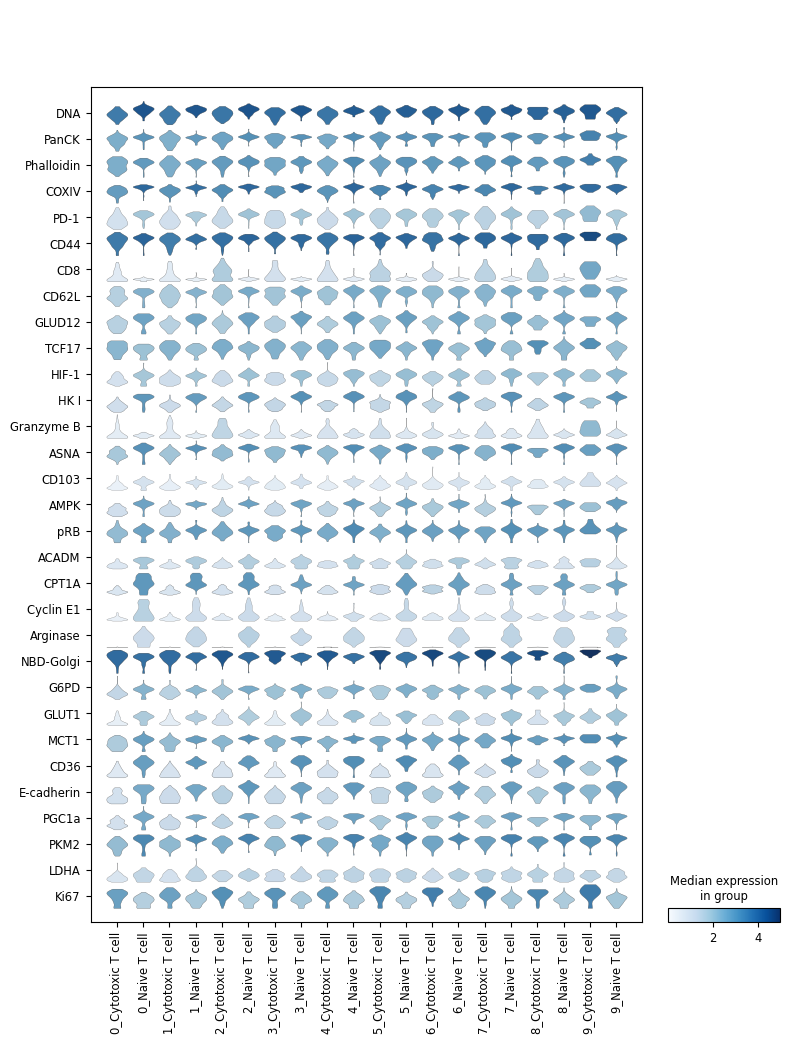

In [148]:
# import scanpy as sc
# markers = adata_cancer.var_names.values
# sc.pl.stacked_violin(adata_cancer, markers, groupby = 'group', swap_axes = True)


In [ ]:
# Boxplot per cell
import seaborn as sns
plotting = {
    "data": df_melt_all_corrected,
    "x": "Marker",
    "y": "Expression",
    "hue": "Cell Type"
}

plot(plotting)
sns.despine()

In [51]:
# # Get distance
# centroid_all = centroid[df_cell_intensity.Cell_type_name != 'Other']
# centroid_tcell = centroid_all[df.Cell_type_name == 'T-cell']
# d = get_distance(centroid_tcell, centroid_all)

# # Assign to dataframe
# df['Distance to T-cell'] = d

In [44]:
# # Get distance
# df_cancer = df[df.Cell_type_name == 'Cancer cell'].copy()
# df_cancer.drop(['Cell_type_name'], axis=1, inplace=True)
# df_cancer.sort_values('Distance to T-cell', inplace=True)

# # Quantile cut
# n_cut = 10
# df_cancer[f'Distance T-cell'] = pd.qcut(df_cancer['Distance to T-cell'], n_cut, duplicates='drop') 

# # Label encoder
# LE = LabelEncoder()
# df_cancer[f'Distance T-cell'] = LE.fit_transform(df_cancer[f'Distance T-cell'])

# # Melt dataframe
# df_melt = df_cancer.drop(['Distance to T-cell'], axis=1).melt(id_vars='Distance T-cell', var_name='Marker', value_name='Expression')



# Get distance
df_cancer_cyto = df_both_cytotoxic[df_both_cytotoxic.Cell_type_name == 'Cancer cell'].copy()
df_cancer_cyto.drop(['Cell_type_name'], axis=1, inplace=True)
df_cancer_cyto.sort_values('Distance to T-cell', inplace=True)

# Quantile cut
n_cut = 10
df_cancer_cyto[f'Distance T-cell'] = pd.qcut(df_cancer_cyto['Distance to T-cell'], n_cut, duplicates='drop') 

# Label encoder
LE = LabelEncoder()
df_cancer_cyto[f'Distance T-cell'] = LE.fit_transform(df_cancer_cyto[f'Distance T-cell'])

# Melt dataframe
df_melt_cyto = df_cancer_cyto.drop(['Distance to T-cell'], axis=1).melt(id_vars='Distance T-cell', var_name='Marker', value_name='Expression')

In [105]:
# Get distance
df_cancer_naive = df_both_naive[df_both_naive.Cell_type_name == 'Cancer cell'].copy()
df_cancer_naive.drop(['Cell_type_name'], axis=1, inplace=True)
df_cancer_naive.sort_values('Distance to T-cell', inplace=True)

# Quantile cut
n_cut = 10
df_cancer_naive[f'Distance T-cell'] = pd.qcut(df_cancer_naive['Distance to T-cell'], n_cut, duplicates='drop') 

# Label encoder
LE = LabelEncoder()
df_cancer_naive[f'Distance T-cell'] = LE.fit_transform(df_cancer_naive[f'Distance T-cell'])

# Melt dataframe
df_melt_naive= df_cancer_naive.drop(['Distance to T-cell'], axis=1).melt(id_vars='Distance T-cell', var_name='Marker', value_name='Expression')

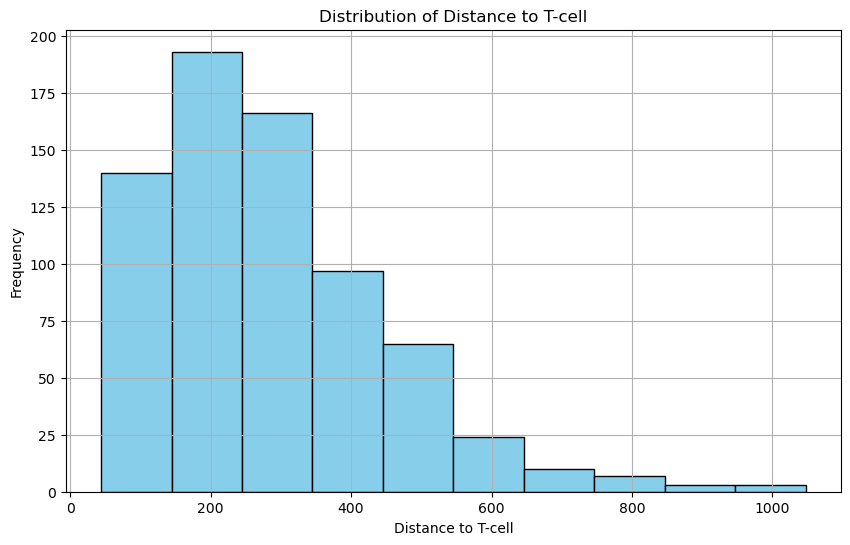

In [207]:
# import matplotlib.pyplot as plt

# # Assuming df is your dataframe
# # Replace 'Distance to T-cell' with the actual column name if it's different
# distance_to_tcell = df_cancer_cyto['Distance to T-cell']

# # Create a histogram to visualize the distribution
# plt.figure(figsize=(10, 6))
# plt.hist(distance_to_tcell, bins=10, color='skyblue', edgecolor='black')
# plt.title('Distribution of Distance to T-cell')
# plt.xlabel('Distance to T-cell')
# plt.ylabel('Frequency')
# plt.grid(True)
# plt.show()


C:\Users\mwang698\AppData\Local\anaconda3\Lib\site-packages\anndata\_core\anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


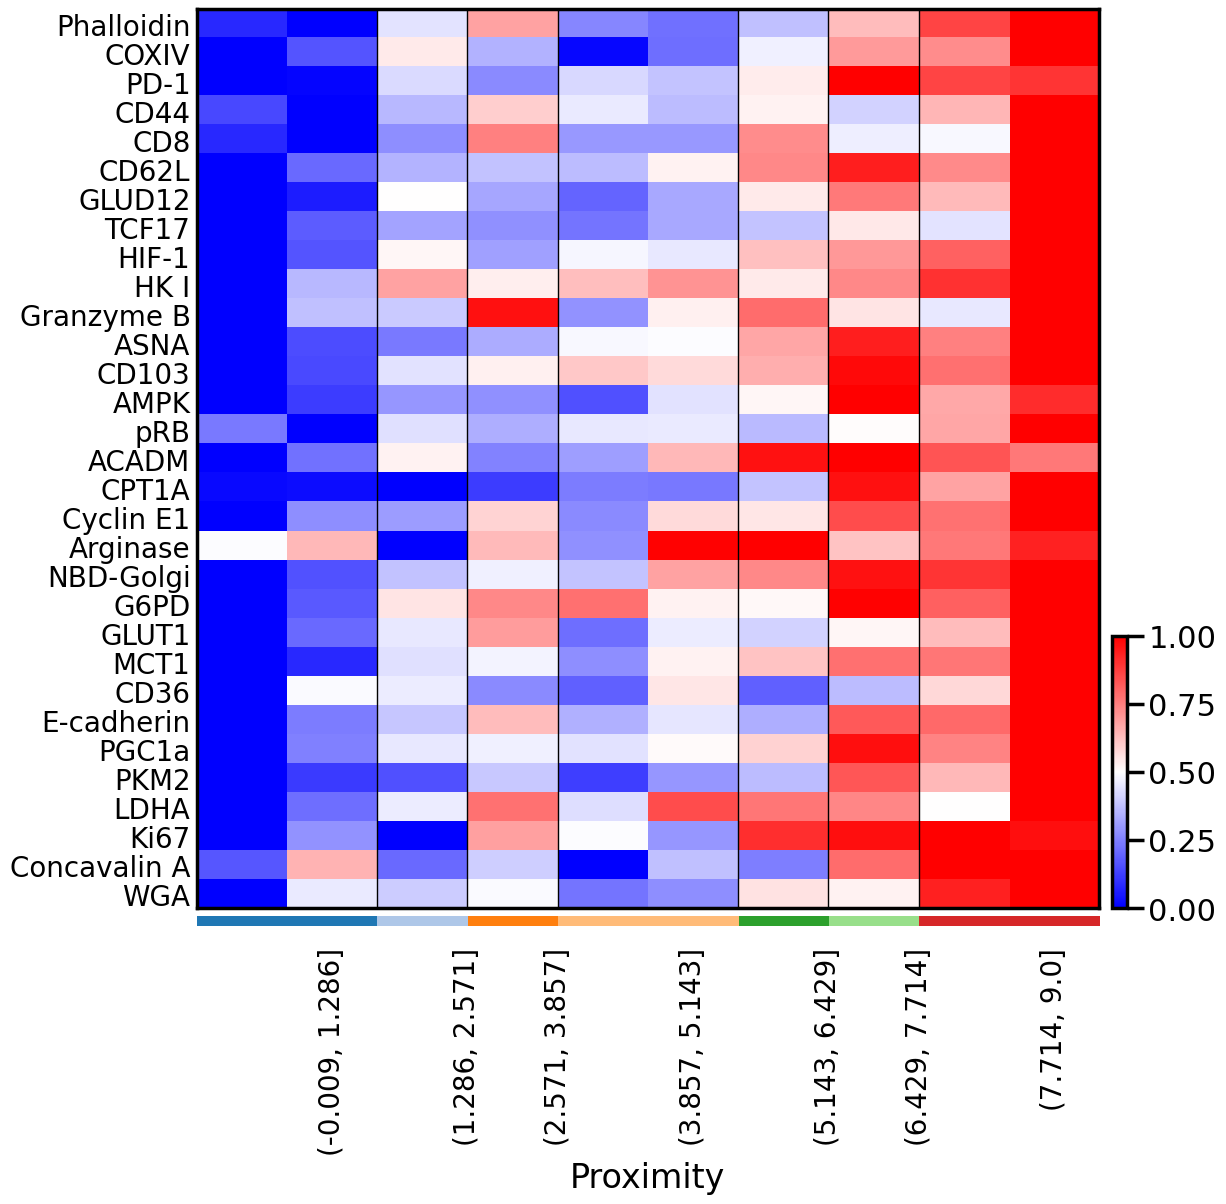

In [284]:
df_sort_cyto = df_cancer_cyto.drop(['DNA', 'Distance to T-cell', 'Row', 'Cols', 'FOV', 'Cell Type', 'Cell_label'], axis=1).groupby('Distance T-cell').median()

adata = sc.AnnData(df_sort_cyto.iloc[:,1:])
adata.var_names = df_sort_cyto.iloc[:,1:].columns.tolist()
adata.obs['Proximity'] = df_sort_cyto.index.tolist()

adata.X = (adata.X - np.min(adata.X, axis = 0))/(np.max(adata.X, axis = 0) - np.min(adata.X, axis = 0))
with sns.plotting_context('poster', font_scale=1):
    sc.pl.heatmap(adata, adata.var_names, groupby='Proximity', swap_axes=True, cmap='bwr', figsize=(12,12))

C:\Users\mwang698\AppData\Local\anaconda3\Lib\site-packages\anndata\_core\anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


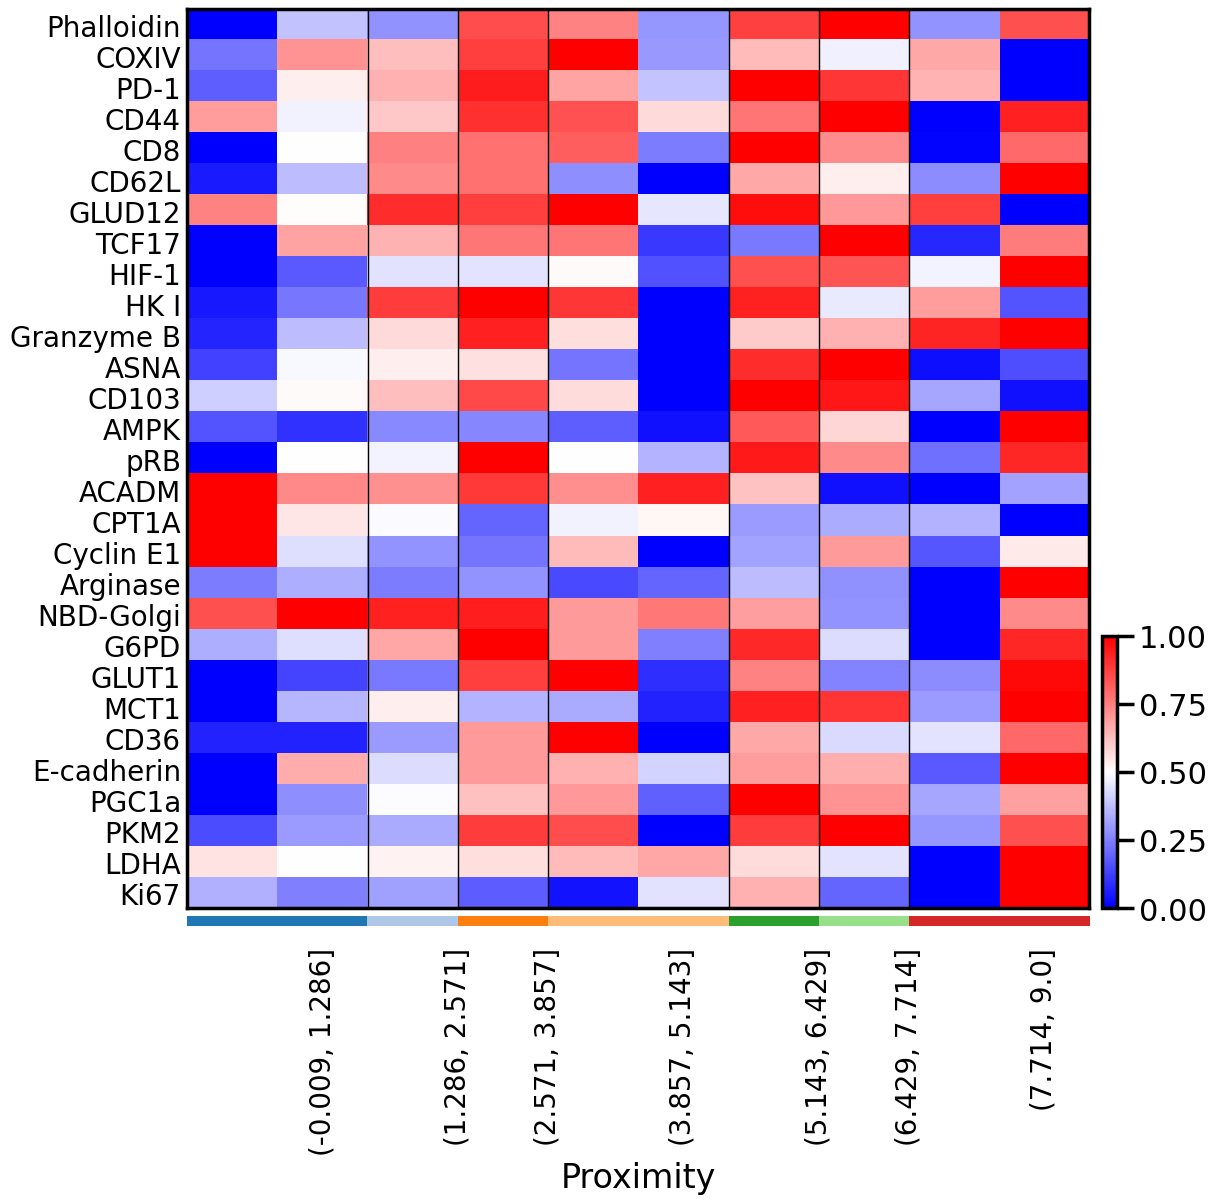

In [285]:
df_sort_naive = df_cancer_naive.drop(['DNA', 'Distance to T-cell', 'Row', 'Cols', 'FOV', 'Cell Type', 'Cell_label'], axis=1).groupby('Distance T-cell').median()

adata = sc.AnnData(df_sort_naive.iloc[:,1:])
adata.var_names = df_sort_naive.iloc[:,1:].columns.tolist()
adata.obs['Proximity'] = df_sort_naive.index.tolist()

adata.X = (adata.X - np.min(adata.X, axis = 0))/(np.max(adata.X, axis = 0) - np.min(adata.X, axis = 0))
with sns.plotting_context('poster', font_scale=1):
    sc.pl.heatmap(adata, adata.var_names, groupby='Proximity', swap_axes=True, cmap='bwr', figsize=(12,12))

In [151]:
from sklearn.neighbors import NearestNeighbors, BallTree
from sklearn.preprocessing import LabelEncoder
import scanpy as sc
import networkx as nx 

def get_distance(centroid_fit, centroid_search, r = 70):
    kdt = BallTree(centroid_fit, metric='euclidean') 
    ind = kdt.query_radius(centroid_search, r=r, return_distance=False)
    
    for i in range(0, len(ind)): ind[i] = np.delete(ind[i], np.argwhere(ind[i] == i))#remove self
    neighbours = pd.DataFrame(ind.tolist()) # neighbour DF

    return neighbours

def visualize_graph(G, pos, color, ax, **kwargs):
    nx.draw_networkx(G, pos=pos, with_labels=False, 
                     node_color=color, ax=ax, **kwargs)
    ax.axis('equal')
    ax.invert_yaxis()
    ax.set_facecolor('k')

from skimage import measure, morphology

def get_contour(mask: np.ndarray):
    """
    Get contours of mask
    """
    contours = []
    for i in sorted(np.unique(mask)):
        if i == 0:
            continue
        contours.append(measure.find_contours(mask == i, 0.8)[0])

    return contours

In [109]:
group_cyto = df_prop_cytotoxic.groupby(['FOV'])

In [110]:
group_cytotoxic = df_prop_cytotoxic.groupby(['FOV'])
dfs_list_cytotoxic = []
for fov, df_group in group_cytotoxic:
    centroid = df_group[['Row', 'Cols']]
    df_group['FOV'] = fov
    # Get distance
#     centroid_all = centroid[df_group.Cell_type_name != 'Other']
    centroid_tcell = centroid[df_group['Cell Type'] == 2]
    centroid_tumour = centroid[df_group['Cell Type'] == 1]

    ###### T cell neighbors for Cancer cells
    # Get distance
    neighbours = get_distance(centroid_tcell, centroid_tumour, r=145)
    assert len(neighbours) == len(centroid_tumour)

    # # Assign to dataframe
    df_group['T_cell_neihgbors'] = False
    df_group.loc[df_group['Cell Type'] == 1, 'T_cell_neihgbors'] = neighbours.any(1).tolist()
# #     df_group.loc[df_group['Cell Type'] == 'Cancer cell', 'T_cell_neihgbors'] = neighbours.any(1).tolist()
#     cancer_cell_indices = df_group[df_group['Cell Type'] == 1].index
#     for idx in cancer_cell_indices:
#         df_group.at[idx, 'T_cell_neighbors'] = neighbours.any(1).tolist()[idx]


    ### Cancer cell neighbors for T cells
    # Get distance
    neighbours = get_distance(centroid_tumour, centroid_tcell, r=145)
    assert len(neighbours) == len(centroid_tcell)

    # # Assign to dataframe
    df_group['Tumour_neihgbors'] = False
#     df_group.loc[df_group.Cell_type_name == 'T-cell', 'Tumour_neihgbors'] = neighbours.any(1).tolist()
    df_group.loc[df_group['Cell Type'] == 2, 'Tumour_neihgbors'] = neighbours.any(1).tolist()
#     T_cell_indices = df_group[df_group['Cell Type'] == 2].index
#     for idx in T_cell_indices:
#         df_group.at[idx, 'T_cell_neighbors'] = neighbours.any(1).tolist()[idx]
    dfs_list_cytotoxic.append(df_group)

C:\Users\mwang698\AppData\Local\Temp\ipykernel_112580\155073632.py:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for fov, df_group in group_cytotoxic:
C:\Users\mwang698\AppData\Local\Temp\ipykernel_112580\155073632.py:18: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  df_group.loc[df_group['Cell Type'] == 1, 'T_cell_neihgbors'] = neighbours.any(1).tolist()
C:\Users\mwang698\AppData\Local\Temp\ipykernel_112580\155073632.py:33: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  df_group.loc[df_group['Cell Type'] == 2, 'Tumour_neihgbors'] = neighbours.any(1).tolist()
C:\Users\mwang698\AppData\Local\Temp\ipykernel_112580\155073632.py:18: FutureWarning: In a future version of pandas all

In [111]:
group_naive = df_prop_naive.groupby(['FOV'])
dfs_list_naive = []
for fov, df_group in group_naive:
    centroid = df_group[['Row', 'Cols']]
    df_group['FOV'] = fov
    # Get distance
#     centroid_all = centroid[df_group.Cell_type_name != 'Other']
    centroid_tcell = centroid[df_group['Cell Type'] == 2]
    centroid_tumour = centroid[df_group['Cell Type'] == 1]

    ###### T cell neighbors for Cancer cells
    # Get distance
    neighbours = get_distance(centroid_tcell, centroid_tumour, r=143)
    assert len(neighbours) == len(centroid_tumour)

    # # Assign to dataframe
    df_group['T_cell_neihgbors'] = False
    df_group.loc[df_group['Cell Type'] == 1, 'T_cell_neihgbors'] = neighbours.any(1).tolist()
# #     df_group.loc[df_group['Cell Type'] == 'Cancer cell', 'T_cell_neihgbors'] = neighbours.any(1).tolist()
#     cancer_cell_indices = df_group[df_group['Cell Type'] == 1].index
#     for idx in cancer_cell_indices:
#         df_group.at[idx, 'T_cell_neighbors'] = neighbours.any(1).tolist()[idx]


    ### Cancer cell neighbors for T cells
    # Get distance
    neighbours = get_distance(centroid_tumour, centroid_tcell, r=143)
    assert len(neighbours) == len(centroid_tcell)

    # # Assign to dataframe
    df_group['Tumour_neihgbors'] = False
#     df_group.loc[df_group.Cell_type_name == 'T-cell', 'Tumour_neihgbors'] = neighbours.any(1).tolist()
    df_group.loc[df_group['Cell Type'] == 2, 'Tumour_neihgbors'] = neighbours.any(1).tolist()
#     T_cell_indices = df_group[df_group['Cell Type'] == 2].index
#     for idx in T_cell_indices:
#         df_group.at[idx, 'T_cell_neighbors'] = neighbours.any(1).tolist()[idx]
    dfs_list_naive.append(df_group)

C:\Users\mwang698\AppData\Local\Temp\ipykernel_112580\3554029393.py:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for fov, df_group in group_naive:
C:\Users\mwang698\AppData\Local\Temp\ipykernel_112580\3554029393.py:18: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  df_group.loc[df_group['Cell Type'] == 1, 'T_cell_neihgbors'] = neighbours.any(1).tolist()
C:\Users\mwang698\AppData\Local\Temp\ipykernel_112580\3554029393.py:33: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  df_group.loc[df_group['Cell Type'] == 2, 'Tumour_neihgbors'] = neighbours.any(1).tolist()
C:\Users\mwang698\AppData\Local\Temp\ipykernel_112580\3554029393.py:18: FutureWarning: In a future version of pandas all

In [112]:
from statannotations.Annotator import Annotator

def plot(plotting, figsize=(24,7)):
    c1, c2 = plotting['data'][plotting['hue']].unique()
    pairs = [((e, c1), (e, c2)) for e in plotting['data'][plotting['x']].unique()]

    with sns.plotting_context('talk', font_scale=1.5):
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.boxplot(**plotting, showfliers=False, ax=ax)
        # ax = sns.swarmplot(**plotting, ax=ax, dodge=True, size=2.5)
        annot = Annotator(ax, pairs, **plotting)
        annot.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=0)
        result = annot.apply_test().annotate()
        plt.xticks(rotation=30, ha='right')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

def plot2(plotting, figsize=(24,7)):
    c1, c2 = plotting['data'][plotting['hue']].unique()
    pairs = [((e, c1), (e, c2)) for e in plotting['data'][plotting['x']].unique()]

    with sns.plotting_context('talk', font_scale=1.5):
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.violinplot(**plotting, showfliers=False, ax=ax)
        annot = Annotator(ax, pairs, **plotting)
        annot.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose=0)
        result = annot.apply_test().annotate()
        plt.xticks(rotation=30, ha='right')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

In [113]:
from statannotations.Annotator import Annotator

def plot(plotting, figsize=(24,7)):
    c1, c2 = plotting['data'][plotting['hue']].unique()
    pairs = [((e, c1), (e, c2)) for e in plotting['data'][plotting['x']].unique()]

    with sns.plotting_context('talk', font_scale=1.5):
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.boxplot(**plotting, showfliers=False, ax=ax)
        # ax = sns.swarmplot(**plotting, ax=ax, dodge=True)
        annot = Annotator(ax, pairs, **plotting)
        annot.configure(test='Mann-Whitney' ,comparisons_correction="bonferroni",text_format='star', loc='inside', verbose=0)
        result = annot.apply_test().annotate()
        plt.xticks(rotation=30, ha='right')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

In [114]:
df_final_cytotoxic = pd.concat(dfs_list_cytotoxic)
df_final_naive = pd.concat(dfs_list_naive)

In [115]:
df_naive_value = df_final_naive.iloc[:,1:32].copy()
df_naive_value_norm = (df_naive_value - df_naive_value.min()) / (df_naive_value.max() - df_naive_value.min())
df_naive_value_norm = df_naive_value_norm.loc[:,~df_naive_value_norm.columns.duplicated()].copy()

phalloidin_mean = df_naive_value_norm['Phalloidin'].mean()
    
for column in df_naive_value_norm.columns:
    df_naive_value_norm[column] -= phalloidin_mean
        
df_final_naive.iloc[:,1:32] = df_naive_value_norm

In [116]:
df_cytotoxic_value = df_final_cytotoxic.iloc[:,1:34].copy()
df_cytotoxic_value_norm = (df_cytotoxic_value - df_cytotoxic_value.min()) / (df_cytotoxic_value.max() - df_cytotoxic_value.min())
df_cytotoxic_value_norm = df_cytotoxic_value_norm.loc[:,~df_cytotoxic_value_norm.columns.duplicated()].copy()

phalloidin_mean = df_cytotoxic_value_norm['Phalloidin'].median()
    
for column in df_cytotoxic_value_norm.columns:
    df_cytotoxic_value_norm[column] -= phalloidin_mean
        
# df_cytotoxic_value_norm['Cell_type_name'] = df_cytotoxic['Cell_type_name']
df_final_cytotoxic.iloc[:,1:34] = df_cytotoxic_value_norm

In [117]:
df_subset = df_final_cytotoxic[df_final_cytotoxic['Cell Type'] == 1].iloc[:,1:-7]
# df_subset['T-cell nei'] = df[df.Cell_type_name == 'Cancer cell']['T_cell_neihgbors']
df_subset['T-cell nei'] = df_final_cytotoxic[df_final_cytotoxic['Cell Type'] == 1]['T_cell_neihgbors']
df_melt_cytotoxic = df_subset.melt(id_vars='T-cell nei', var_name='Marker', value_name='Intensity')

df_subset = df_final_naive[df_final_naive['Cell Type'] == 1].iloc[:,1:-7]
# df_subset['T-cell nei'] = df[df.Cell_type_name == 'Cancer cell']['T_cell_neihgbors']
df_subset['T-cell nei'] = df_final_naive[df_final_naive['Cell Type'] == 1]['T_cell_neihgbors']
df_melt_naive = df_subset.melt(id_vars='T-cell nei', var_name='Marker', value_name='Intensity')


In [118]:
df_melt_cytotoxic = df_melt_cytotoxic[df_melt_cytotoxic['T-cell nei'] == True]
df_melt_cytotoxic = df_melt_cytotoxic[~(df_melt_cytotoxic['Marker'] == 'WGA')]
df_melt_cytotoxic = df_melt_cytotoxic[~(df_melt_cytotoxic['Marker'] == 'Concavalin A')]
df_melt_cytotoxic['Neighbor_T_cell'] = 'Cytotoxic T cell'

In [119]:
df_melt_naive = df_melt_naive[df_melt_naive['T-cell nei'] == True]
df_melt_naive['Neighbor_T_cell'] = 'Naive T cell'

In [120]:
df_melt_all = pd.concat([df_melt_cytotoxic, df_melt_naive])

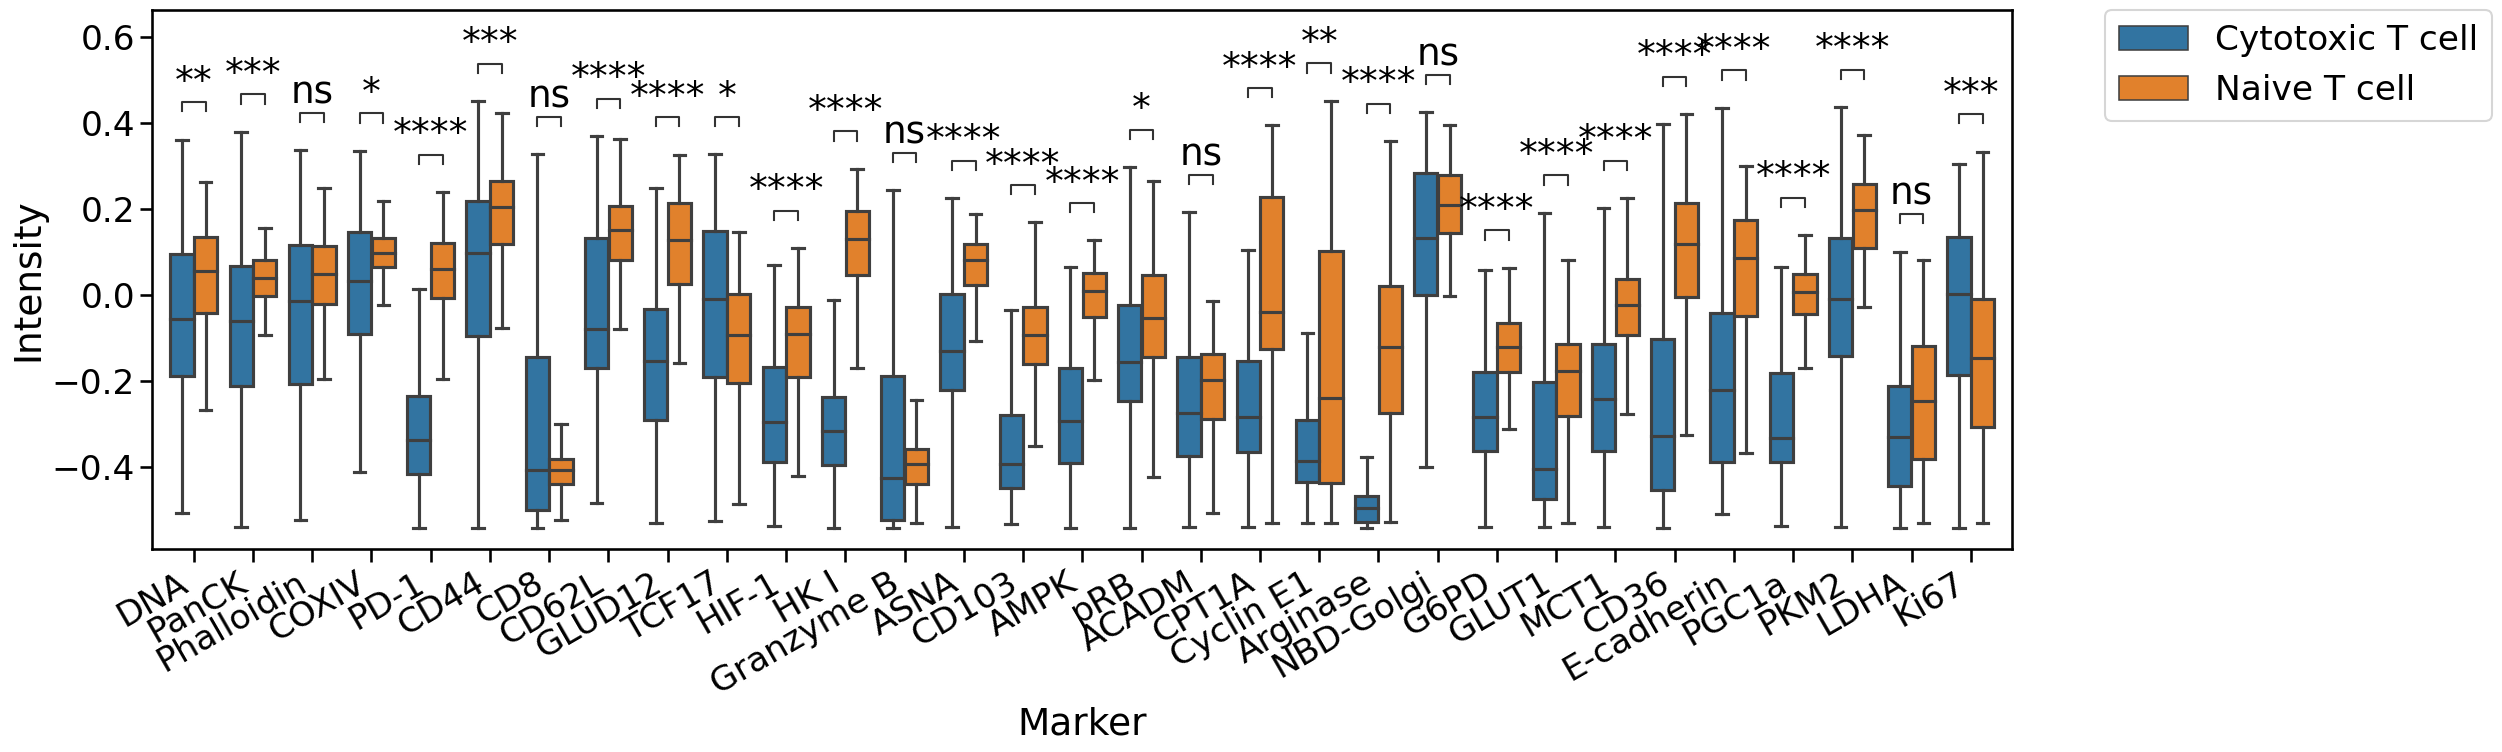

In [121]:
# Cancer cell metabolic profile tumour cell when compared to neighoring or not T cell
# df_subset = df[df.Cell_type_name == 'Cancer cell'].iloc[:,1:-7]
# df_subset = df[df['Cell Type'] == 1].iloc[:,1:-6]
# # df_subset['T-cell nei'] = df[df.Cell_type_name == 'Cancer cell']['T_cell_neihgbors']
# df_subset['T-cell nei'] = df[df['Cell Type'] == 1]['T_cell_neihgbors']
# df_melt = df_subset.melt(id_vars='T-cell nei', var_name='Marker', value_name='Intensity')

# Plot
# Boxplot per cell
plotting = {
    "data": df_melt_all, 
    "x": "Marker",
    "y": "Intensity",
    "hue": "Neighbor_T_cell"
}

plot(plotting)

In [122]:
df_subset = df_final_cytotoxic[df_final_cytotoxic['Cell Type'] == 2].iloc[:,1:-7]
# df_subset['T-cell nei'] = df[df.Cell_type_name == 'Cancer cell']['T_cell_neihgbors']
df_subset['Tumour_neihgbors'] = df_final_cytotoxic[df_final_cytotoxic['Cell Type'] == 2]['Tumour_neihgbors']
df_melt_cytotoxic = df_subset.melt(id_vars='Tumour_neihgbors', var_name='Marker', value_name='Intensity')

df_subset = df_final_naive[df_final_naive['Cell Type'] == 2].iloc[:,1:-7]
# df_subset['T-cell nei'] = df[df.Cell_type_name == 'Cancer cell']['T_cell_neihgbors']
df_subset['Tumour_neihgbors'] = df_final_naive[df_final_naive['Cell Type'] == 2]['Tumour_neihgbors']
df_melt_naive = df_subset.melt(id_vars='Tumour_neihgbors', var_name='Marker', value_name='Intensity')


In [123]:
df_melt_cytotoxic = df_melt_cytotoxic[df_melt_cytotoxic['Tumour_neihgbors'] == True]
df_melt_cytotoxic = df_melt_cytotoxic[~(df_melt_cytotoxic['Marker'] == 'WGA')]
df_melt_cytotoxic = df_melt_cytotoxic[~(df_melt_cytotoxic['Marker'] == 'Concavalin A')]
df_melt_cytotoxic['cell_type'] = 'Cytotoxic T cell'

In [124]:
df_melt_naive = df_melt_naive[df_melt_naive['Tumour_neihgbors'] == True]
df_melt_naive['cell_type'] = 'Naive T cell'

In [125]:
df_melt_all = pd.concat([df_melt_cytotoxic, df_melt_naive])

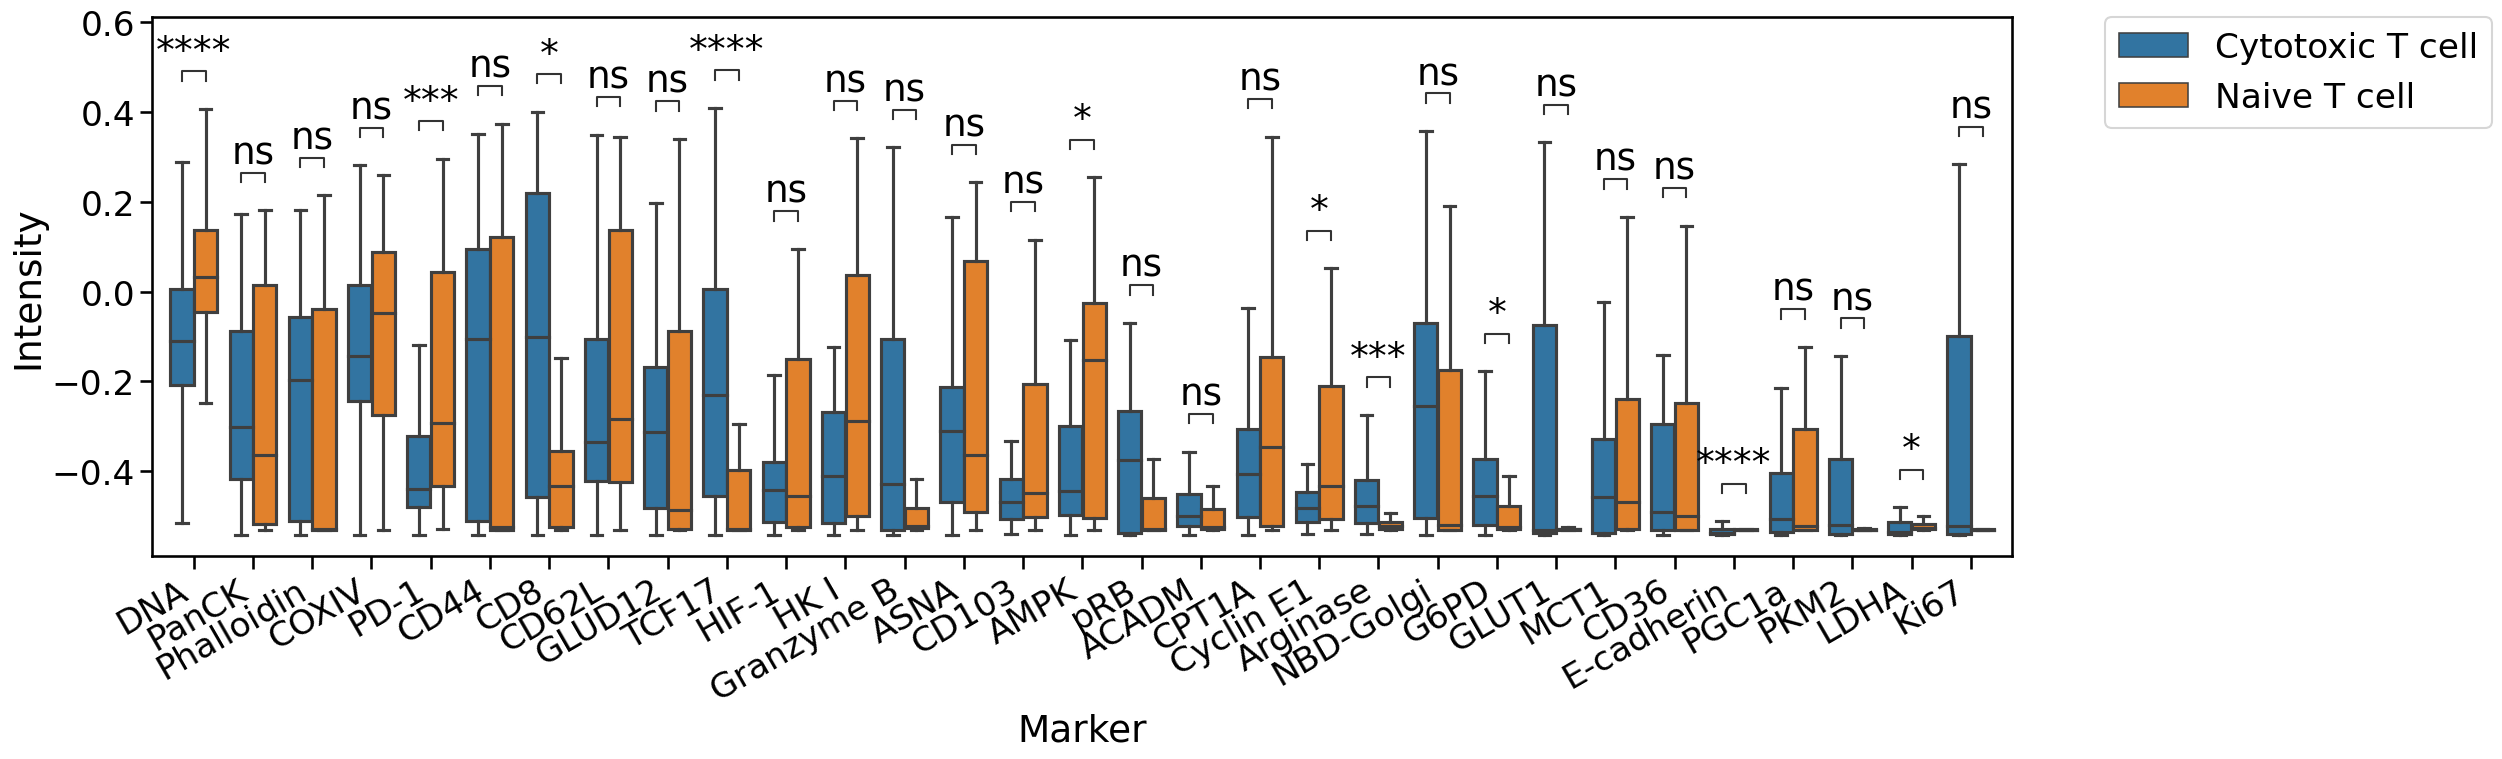

In [126]:
# Cancer cell metabolic profile t cell when compared to neighoring or not Tumor cell
# df_subset = df[df.Cell_type_name == 'T-cell'].iloc[:,1:-7]
# df_subset = df[df['Cell Type'] == 2].iloc[:,1:-6]
# # df_subset['Tumor nei'] = df[df.Cell_type_name == 'T-cell']['Tumour_neihgbors']
# df_subset['Tumor nei'] = df[df['Cell Type'] == 2]['Tumour_neihgbors']
# df_melt = df_subset.melt(id_vars='Tumor nei', var_name='Marker', value_name='Intensity')

# Plot
# Boxplot per cell
plotting = {
    "data": df_melt_all, 
    "x": "Marker",
    "y": "Intensity",
    "hue": "cell_type"
}

plot(plotting)